In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [3]:
def Exact_NEIM(mu, f, U, max_modes=25):
    """
    Compute a non-neural network NEIM for solution
    independent nonlinearities.
    
    mu: parameters
    f:  nonlinearity corresponding to each mu in a matrix
    U:  POD basis
    """
    
    Pf = U.T @ f # projection of f
    
    selected_parameters = []
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    idx = np.argmax([np.linalg.norm(Pf[:, i])**2 for i in range(Pf.shape[1])])
    mu_1 = mu[idx]
    selected_parameters.append(mu_1)
    selected_indices.append(idx)
    
    NN_1 = np.copy(Pf[:, [idx]])
    NN_1 /= np.linalg.norm(NN_1)
    trained_networks.append(NN_1)
    thetas = np.array([np.dot(NN_1.reshape(-1), Pf[:, i])/np.linalg.norm(NN_1)**2 for i in range(Pf.shape[1])])
    current_approximation = thetas * NN_1
    
    # NEIM Update Step
    for i in range(1, max_modes):
        idx = np.argmax([np.linalg.norm(current_approximation[:, i] - Pf[:, i])**2 for i in range(Pf.shape[1])])
        mu_i = mu[idx]
        selected_parameters.append(mu_i)
        selected_indices.append(idx)
        
        # orthogonalize selected vector with respect to previous vectors
        NN_i = Pf[:, [idx]]
        for network in trained_networks:
            NN_i -= np.dot(NN_i.reshape(-1), network.reshape(-1)) * network / np.linalg.norm(network)**2
        NN_i /= np.linalg.norm(NN_i)
        
        trained_networks.append(NN_i)
        A = np.zeros((i+1, i+1))
        for j in range(A.shape[0]):
            for k in range(A.shape[1]):
                A[j, k] = np.dot(trained_networks[j].reshape(-1), trained_networks[k].reshape(-1))
        
        thetas = []
        for j in range(Pf.shape[1]):
            b = np.zeros((i+1, 1))
            for k in range(b.shape[0]):
                b[k, 0] = np.dot(trained_networks[k].reshape(-1), Pf[:, j])
            thetas.append(np.linalg.solve(A, b).reshape(-1))
        thetas = np.array(thetas).T
        current_approximation = np.array(trained_networks)[:, :, 0].T @ thetas
    
    trained_networks = np.array(trained_networks)[:, :, 0].T
    
    def Exact_NEIM_approximation(new_mu, num_modes=-1):
        if num_modes == -1:
            num_modes = trained_networks.shape[1]
        thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='cubic').reshape(-1, 1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='nearest').reshape(-1, 1)
        return U @ (trained_networks[:, :num_modes] @ thetas_[:num_modes])
    
    return Exact_NEIM_approximation, selected_indices

In [4]:
# Note that in the example, there is no actual input for
# the neural network. Instead, to simulate NEIM, we will
# choose a simple "solution".

def solution_fn(mu, f):
    # compute full order solutions
    sols = np.zeros((mu.shape[0], f.shape[0]), dtype=np.double)
    A = 2*np.eye(f.shape[0], dtype=np.double) - np.eye(f.shape[0], k=1, dtype=np.double) - np.eye(f.shape[0], k=-1, dtype=np.double)
    A = 30 * A
    A = A[1:-1, 1:-1]
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = np.zeros((f.shape[0], 1), dtype=np.double)
        sol[1:-1] = np.linalg.solve(A, f[1:-1, [i]])
        sol = sol.reshape(-1)
        sols[i] = sol
            
    return sols

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 1)
        #self.fc2 = nn.Linear(30, 30)
        #self.fc4 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(1, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        #x = self.fc2(x)
        #x = torch.tanh(x)
        #x = self.fc4(x)
        #x = torch.tanh(x)
        x = self.fc3(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.zeros(NUM_PARAMS)
    for i in range(NUM_PARAMS):
        # compute error
        s = 0
        for j in range(NUM_PARAMS):
            s += np.sum(f_NEIM[i, j]**2)
        errors[i] = s / NUM_PARAMS
    
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(f_NEIM[idx], dtype=torch.double)
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = criterion(output, y_data)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        #scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
            numerator += np.dot(f_NEIM[i, j], net_u_mu)
            denominator += np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        errors = np.zeros(NUM_PARAMS)
        for i in range(NUM_PARAMS):
            # compute error
            s = 0
            for j in range(NUM_PARAMS):
                s += np.sum((f_NEIM[i, j] - approx(ro_sols[j], i))**2)
            errors[i] = s / NUM_PARAMS
    
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        y_data = f_NEIM[mu_2_idx]

        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)

            # subtract out projection of y_data onto previous_net_matrix from y_data
            y_data -= np.sum(y_data * previous_net_matrix) / np.linalg.norm(previous_net_matrix)**2 * previous_net_matrix

        y_data = torch.tensor(y_data)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = criterion(output, y_data)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            #scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS_numerator = np.zeros((num_nets, num_nets), dtype=np.double)
            LHS_denominator = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS_numerator = np.zeros((num_nets, 1), dtype=np.double)
            RHS_denominator = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]

                for k1 in range(num_nets):
                    RHS_numerator[k1] += np.dot(f_NEIM[i, j], nets_u_mu[k1])
                    RHS_denominator[k1] += np.dot(nets_u_mu[k1], nets_u_mu[k1])
                    for k2 in range(num_nets):
                        LHS_numerator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k2])
                        LHS_denominator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k1])

            LHS = LHS_numerator / LHS_denominator
            RHS = RHS_numerator / RHS_denominator
            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return (V @ s.reshape(-1, 1)).reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathcal{D}\to\mathbb{R}$ defined by $$s(x;\mu) = (1-x)\cos(3\pi\mu(x+1))e^{-(1+x)\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{D} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equidistantly spaced points in $\Omega$ for $i=1,\dots,n$, $n=100$. Define $f:\mathcal{D}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1;\mu),\dots,s(x_n;\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{D}$. 

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

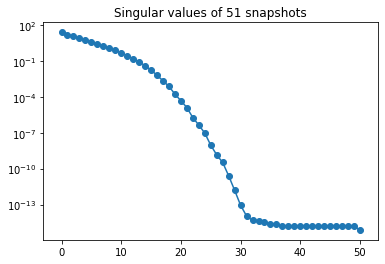

In [5]:
def s(x, mu):
    return (1-x)*np.cos(3*np.pi*mu*(x+1))*np.exp(-(1+x)*mu)

x = np.linspace(-1, 1, 100).reshape(-1,1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
f = s(x, mu) # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

In [ ]:
RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.semilogy(np.arange(sing_vals.shape[0]), sing_vals)
plt.show()
print(V.shape)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

In [ ]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    exact = s(x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for POD, DEIM, Exact NEIM
Exact NEIM is the version of NEIM for nonlinearities which do not depend on solutions (they depend on space and parameters). In this case, NEIM should approximate constant vectors in its expansion, so we instead use these exact vectors.

**If you want better results for Exact NEIM, increase NUM_TRAIN_PARAMS**

0 Max Error: 29.34020414554605 Mean Error: 18.003543215002313
0 1.33877375821667
100 1.0998324891914966
200 0.977311481633253
300 0.8711056037784043
400 0.7337860941715354
500 0.5273137502208296
600 0.35717088596579594
700 0.2590821089592398
800 0.19987281931417625
900 0.16029014748674533
1000 0.13160207060462628
1100 0.10953503896022727
1200 0.09182205428143002
1300 0.07718864858587941
1400 0.06488015786761625
1500 0.05442221632844872
1600 0.045495023338102875
1700 0.03786654048009938
1800 0.03135673475318169
1900 0.025818249490060508
2000 0.021125804466735083
2100 0.017170255468371937
2200 0.013855149356203732
2300 0.011094620901672753
2400 0.008812017788214282
2500 0.0069389285417044665
2600 0.005414440160649903
2700 0.00418453102526717
2800 0.0032015452036538924
2900 0.0024237155222597852
3000 0.0018147146466348783
3100 0.001343220856633065
3200 0.0009824905038813806
3300 0.0007099333012910641
3400 0.0005066899812756204
3500 0.0003572145570467162
3600 0.000248865408024044
3700 0.00

29700 8.518175039019777e-09
29800 8.314970649324862e-09
29900 8.139962865864513e-09
30000 7.942657582804889e-09
30100 7.762841467236405e-09
30200 7.599942984995414e-09
30300 7.424989172364611e-09
30400 7.272796327906355e-09
30500 7.10944519112896e-09
30600 6.968249371417552e-09
30700 6.812861193477612e-09
30800 6.672703923109068e-09
30900 6.539021943397332e-09
31000 6.403343176683335e-09
31100 6.275292230833378e-09
31200 6.157624337696541e-09
31300 6.036038726086608e-09
31400 5.935395250418777e-09
31500 5.810071386987865e-09
31600 5.6979096703612395e-09
31700 5.589023678486933e-09
31800 5.48666939662614e-09
31900 5.390283444059871e-09
32000 5.291537904347947e-09
32100 5.217909934378758e-09
32200 5.113020377727051e-09
32300 5.023117866163746e-09
32400 4.937155780260937e-09
32500 4.856105413787061e-09
32600 4.789654254175414e-09
32700 4.696347688868878e-09
32800 4.622584840161297e-09
32900 4.548272059425107e-09
33000 4.4774151408274555e-09
33100 4.4103114440094086e-09
33200 4.34189672791

8800 7.532405902327257e-06
8900 7.2707129678897885e-06
9000 7.017012810687783e-06
9100 6.771139271491746e-06
9200 6.5329240308479815e-06
9300 6.302197110202355e-06
9400 6.078787343188413e-06
9500 5.862522817392165e-06
9600 5.653231287047594e-06
9700 5.45074055724377e-06
9800 5.254878840331211e-06
9900 5.0654750853087505e-06
10000 4.882359281049871e-06
10100 4.705362734289411e-06
10200 4.534318323342767e-06
10300 4.369060728569566e-06
10400 4.209426640618058e-06
10500 4.05525494750823e-06
10600 3.906386901616701e-06
10700 3.7626662676303417e-06
10800 3.6239394525281285e-06
10900 3.4900556186377667e-06
11000 3.360866780798324e-06
11100 3.2362278886359574e-06
11200 3.115996894934822e-06
11300 3.0000348110556202e-06
11400 2.8882057503240325e-06
11500 2.780376960274791e-06
11600 2.6764188446044326e-06
11700 2.5762049756482643e-06
11800 2.479612098159177e-06
11900 2.386520125130104e-06
12000 2.2968121263624944e-06
12100 2.2103743104473022e-06
12200 2.127096000786847e-06
12300 2.0468696062502

38000 1.2589284228745026e-09
38100 1.250017711830563e-09
38200 1.2434274523840893e-09
38300 1.23396454670935e-09
38400 1.2245935222319767e-09
38500 1.2171263738741317e-09
38600 1.2084349792689464e-09
38700 1.2026764762995747e-09
38800 1.1932711664284932e-09
38900 1.1855372627976828e-09
39000 1.178456226891013e-09
39100 1.1734563274827541e-09
39200 1.1641300059973039e-09
39300 1.1571470575718163e-09
39400 1.1504070793276922e-09
39500 1.1454810472054354e-09
39600 1.1375693757006276e-09
39700 1.1309736484666216e-09
39800 1.1247497040621636e-09
39900 1.119582487816489e-09
40000 1.1141321504727873e-09
40100 1.1067984730177509e-09
40200 1.101038962647496e-09
40300 1.0986362563981977e-09
40400 1.09014333021629e-09
40500 1.0844275758218114e-09
40600 1.0790841924584726e-09
40700 1.0757355318027243e-09
40800 1.0687423253284648e-09
40900 1.0636837724454102e-09
41000 1.0587486194038602e-09
41100 1.0538581513989084e-09
41200 1.0504254181270804e-09
41300 1.044399658222074e-09
41400 1.039795743083916

17600 5.332238776515333e-11
17700 5.33124380891899e-11
17800 1.273507175093463e-10
17900 5.329582688792617e-11
18000 5.328452801279676e-11
18100 5.3275460131290745e-11
18200 7.924203723924033e-11
18300 5.325863699262062e-11
18400 5.324900077679174e-11
18500 5.3240397815837154e-11
18600 2.7985578741930204e-09
18700 5.3231980720214856e-11
18800 5.321528758124198e-11
18900 5.3207118698596046e-11
19000 5.319905368813317e-11
19100 9.420806736448468e-11
19200 5.3183657579705985e-11
19300 7.675091852085766e-11
19400 5.3168539544192973e-11
19500 5.3161390093752445e-11
19600 5.3231756603780215e-11
19700 5.5140054252071086e-11
19800 5.313907867626712e-11
19900 5.313122594475193e-11
20000 5.6601828973190843e-11
20100 5.311703048620494e-11
20200 5.310990384748352e-11
20300 6.665951797429318e-10
20400 5.3106961098908004e-11
20500 5.308961623917902e-11
20600 5.3083007076804066e-11
20700 1.0878984937544314e-10
20800 5.307026630645271e-11
20900 5.306368201181794e-11
21000 5.3057385499802855e-11
21100 

46600 5.252395180785554e-11
46700 5.252340779130621e-11
46800 5.2522995094306746e-11
46900 5.253141154266672e-11
47000 5.2523097790555395e-11
47100 5.2521781956259495e-11
47200 5.252138540908124e-11
47300 5.338529395073118e-11
47400 5.252123859632141e-11
47500 5.451876745835939e-11
47600 5.251988906603778e-11
47700 5.2519461522987336e-11
47800 5.253297175312747e-11
47900 5.2518721789703665e-11
48000 5.2518352453931234e-11
48100 5.254035218702797e-11
48200 5.251763214535756e-11
48300 5.2517276406210835e-11
48400 5.253259111187169e-11
48500 5.251794718337265e-11
48600 5.251623220083175e-11
48700 5.2515890957787335e-11
48800 5.252308531957756e-11
48900 5.251644396770231e-11
49000 5.2514887795318415e-11
49100 5.2514559895416037e-11
49200 5.251423520006174e-11
49300 5.2617764422967655e-11
49400 5.2513600363111556e-11
49500 5.251328098266994e-11
49600 5.251296907253904e-11
49700 5.251266020909969e-11
49800 5.251969731037484e-11
49900 5.251205213502451e-11

Finding theta...
50 Max Error: 10.2

25900 4.32084328850878e-09
26000 4.19218694543472e-09
26100 4.090641866812558e-09
26200 4.006236737871676e-09
26300 3.904562361410829e-09
26400 3.8189251071342924e-09
26500 3.723032192829515e-09
26600 3.632997510121636e-09
26700 3.5738778572380324e-09
26800 3.4792345718856232e-09
26900 3.3941449055780618e-09
27000 3.3633475995013723e-09
27100 3.2531047412874953e-09
27200 3.1788557156399185e-09
27300 3.1457666051403916e-09
27400 3.0540497577360827e-09
27500 2.9842095080730377e-09
27600 2.9325036689900625e-09
27700 2.86511293410904e-09
27800 2.8223632497211863e-09
27900 2.7754010092601265e-09
28000 2.700633281702628e-09
28100 2.6492058787924016e-09
28200 2.6246153977561388e-09
28300 2.5515576722216934e-09
28400 2.5050545380825e-09
28500 2.4733286300853167e-09
28600 2.4192914173739666e-09
28700 2.3742493161164693e-09
28800 2.3498344563345062e-09
28900 2.294035729387163e-09
29000 2.2554928617527117e-09
29100 2.232011299780969e-09
29200 2.1894411491304204e-09
29300 2.1479604348753568e-09
29

5400 2.184814699808942e-06
5500 2.1502804697461845e-06
5600 2.115472610884346e-06
5700 2.0804170058849637e-06
5800 2.045140226967201e-06
5900 2.0096694654028617e-06
6000 1.974032456548584e-06
6100 1.938257400904198e-06
6200 1.9023728817180444e-06
6300 1.8664077796897883e-06
6400 1.8303911853486066e-06
6500 1.794352309706989e-06
6600 1.7583203938087953e-06
6700 1.7223246178005093e-06
6800 1.6863940101591856e-06
6900 1.6505573577075697e-06
7000 1.6148431170361397e-06
7100 1.5792793279349564e-06
7200 1.5438935294139347e-06
7300 1.5087126788596617e-06
7400 1.4737630748407444e-06
7500 1.4390702840318558e-06
7600 1.4046590726811346e-06
7700 1.3705533429952584e-06
7800 1.336776074763869e-06
7900 1.30334927249039e-06
8000 1.2702939182396217e-06
8100 1.2376299303558779e-06
8200 1.2053761281494735e-06
8300 1.1735502025932257e-06
8400 1.142168693018221e-06
8500 1.111246969745904e-06
8600 1.0807992225468273e-06
8700 1.050838454770568e-06
8800 1.021376482952072e-06
8900 9.92423941662289e-07
9000 9.

34800 1.3183701818827886e-09
34900 1.3196616641739775e-09
35000 1.3099254990890345e-09
35100 1.3056401247203678e-09
35200 1.3015800834175376e-09
35300 1.3013893962283937e-09
35400 1.293888846192344e-09
35500 1.2899143540053798e-09
35600 1.2861891085657973e-09
35700 1.2836869413939385e-09
35800 1.2792028858024068e-09
35900 1.2754725951150499e-09
36000 1.2720464436982948e-09
36100 1.2711869294948193e-09
36200 1.2673351930309376e-09
36300 1.2621795585665156e-09
36400 1.2590209529290138e-09
36500 1.2559252821569387e-09
36600 1.2623474035897532e-09
36700 1.2499333448491005e-09
36800 1.246998301476733e-09
36900 1.2441372790014326e-09
37000 1.2436788305215371e-09
37100 1.2399264054234355e-09
37200 1.2358786222922034e-09
37300 1.2332291877644187e-09
37400 1.2314896396200672e-09
37500 1.2290804069579683e-09
37600 1.2255742113789453e-09
37700 1.223116116564799e-09
37800 1.2230457648569113e-09
37900 1.2188210450707787e-09
38000 1.21600782196609e-09
38100 1.2137233590453239e-09
38200 1.21147967818

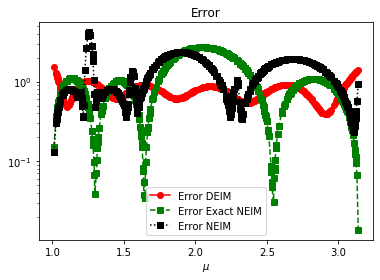

0 Max Error: 29.34020414554605 Mean Error: 17.58335676002728
0 1.135065016651567
100 0.9265900002488852
200 0.773864009301945
300 0.6101080385224785
400 0.4468379181216698
500 0.31772587895198273
600 0.22860170649138184
700 0.16792797378070126
800 0.12546880392489715
900 0.0948016228556535
1000 0.072045351691777
1100 0.0548165909007109
1200 0.041602455525346554
1300 0.031400842166145276
1400 0.023515878200835363
1500 0.017440976561678936
1600 0.012791531752299787
1700 0.009265955326917144
1800 0.006622801575653127
1900 0.004666866665509612
2000 0.0032401831893839974
2100 0.002215642189076347
2200 0.0014920304475726765
2300 0.000989868351354203
2400 0.0006477608796348778
2500 0.0004191457156562419
2600 0.0002694050019158617
2700 0.0001733395349453133
2800 0.00011300903865285722
2900 7.593356507308063e-05
3000 5.3637812801746185e-05
3100 4.0507543106026626e-05
3200 3.291815260930683e-05
3300 2.859086730430204e-05
3400 2.6131762635596954e-05
3500 2.4711976986670853e-05
3600 2.385286904081

29600 5.938284250567825e-09
29700 5.796214833406348e-09
29800 5.6576775302752115e-09
29900 5.525505089998558e-09
30000 5.4073488948737545e-09
30100 5.269894104591158e-09
30200 5.14882785725401e-09
30300 5.038619599350305e-09
30400 4.918557289306292e-09
30500 4.814591878882379e-09
30600 4.709629933518071e-09
30700 4.601461308543517e-09
30800 4.502166876127586e-09
30900 4.410354094991325e-09
31000 4.3139223309196364e-09
31100 4.226638561635403e-09
31200 4.14872683692358e-09
31300 4.053073485706376e-09
31400 3.972791267370661e-09
31500 3.900714912206834e-09
31600 3.816505149305337e-09
31700 3.743529357416684e-09
31800 3.674393070232678e-09
31900 3.6030410084338495e-09
32000 3.5340487391791167e-09
32100 3.4688283286461275e-09
32200 3.416206009130381e-09
32300 3.3456026310830735e-09
32400 3.284913365467229e-09
32500 3.231874572174808e-09
32600 3.1728717019295263e-09
32700 3.1214243821161384e-09
32800 3.068190061069746e-09
32900 3.0143627719525558e-09
33000 2.964183516881659e-09
33100 2.9207

8700 7.199599138434958e-06
8800 7.015099942172212e-06
8900 6.8330593625262536e-06
9000 6.653565861810616e-06
9100 6.476701877770856e-06
9200 6.302543764887564e-06
9300 6.131161760381895e-06
9400 5.962619974101685e-06
9500 5.796976401348267e-06
9600 5.634282957602133e-06
9700 5.474585534017182e-06
9800 5.317924072481818e-06
9900 5.164332658985835e-06
10000 5.013839633990083e-06
10100 4.866467718464352e-06
10200 4.722234154241799e-06
10300 4.581150857334817e-06
10400 4.4432245828618515e-06
10500 4.30845710025107e-06
10600 4.176845377416038e-06
10700 4.048381772628227e-06
10800 3.923054232859498e-06
10900 3.800846497410374e-06
11000 3.6817383056995177e-06
11100 3.5657056081450404e-06
11200 3.4527207791321194e-06
11300 3.3427528311264833e-06
11400 3.235767629059184e-06
11500 3.131728104175019e-06
11600 3.030594466604717e-06
11700 2.9323244159860196e-06
11800 2.836873349522466e-06
11900 2.7441945669311017e-06
12000 2.6542394717866993e-06
12100 2.566957768825159e-06
12200 2.4822976568184434e

38000 2.225203422832452e-09
38100 2.209531591824668e-09
38200 2.1937154993364063e-09
38300 2.178204259915306e-09
38400 2.1620832282378085e-09
38500 2.1473789508158447e-09
38600 2.1345399499540927e-09
38700 2.1185021769445746e-09
38800 2.1048719945582648e-09
38900 2.093386753248063e-09
39000 2.0775542608301685e-09
39100 2.06445459201609e-09
39200 2.053478743794761e-09
39300 2.0390454464165768e-09
39400 2.0267077187544195e-09
39500 2.01940483298613e-09
39600 2.002773182821688e-09
39700 1.9911494434640464e-09
39800 1.9808066589314633e-09
39900 1.9692239376111526e-09
40000 1.957616822914065e-09
40100 1.94686339666842e-09
40200 1.938134715941954e-09
40300 1.9259618967631732e-09
40400 1.9158036563708726e-09
40500 1.9070386456027468e-09
40600 1.8960715393947154e-09
40700 1.886444850028948e-09
40800 1.8792256628323943e-09
40900 1.8678216269205152e-09
41000 1.8586677458646632e-09
41100 1.851027277893651e-09
41200 1.8410350730058714e-09
41300 1.8324154503904356e-09
41400 1.8239407905836946e-09
4

17200 2.3114807273223517e-08
17300 2.237403927274643e-08
17400 2.1678323810325624e-08
17500 2.100040300295584e-08
17600 2.0366188846518327e-08
17700 1.9792353354160145e-08
17800 1.917412164632786e-08
17900 1.863648223443111e-08
18000 1.8094513187185686e-08
18100 1.761875372146123e-08
18200 1.7105444029108604e-08
18300 1.664454495184448e-08
18400 1.6195494171881447e-08
18500 1.5768006541635643e-08
18600 1.5374884195938546e-08
18700 1.494237610273999e-08
18800 1.460172292880883e-08
18900 1.4195335150476399e-08
19000 1.3837540403097696e-08
19100 1.3545328540304295e-08
19200 1.3166153860832412e-08
19300 1.2863760842924366e-08
19400 1.2540922525086179e-08
19500 1.2255425326763033e-08
19600 1.1963264240161256e-08
19700 1.1697015042552997e-08
19800 1.1415159323614464e-08
19900 1.1180530297191472e-08
20000 1.0914160054589279e-08
20100 1.0660314776812764e-08
20200 1.0436881312758935e-08
20300 1.0221268337882636e-08
20400 9.980751408275549e-09
20500 9.763326516747384e-09
20600 9.550045018394706e

46000 1.09898962418925e-09
46100 1.0972611553451641e-09
46200 1.0951123786647202e-09
46300 1.0935008960546678e-09
46400 1.091329532038657e-09
46500 1.0895160543477587e-09
46600 1.0876258334228834e-09
46700 1.086385062775015e-09
46800 1.0840045993204535e-09
46900 1.0822241062849606e-09
47000 1.0804771085774805e-09
47100 1.0787214198338997e-09
47200 1.0771084508240735e-09
47300 1.0753107711724683e-09
47400 1.0736210175241854e-09
47500 1.0720312609950566e-09
47600 1.0703033192764813e-09
47700 1.068690618002683e-09
47800 1.0670886310782527e-09
47900 1.0654825726879796e-09
48000 1.0639511050491222e-09
48100 1.0623584543499656e-09
48200 1.0608386373769517e-09
48300 1.0593058017526245e-09
48400 1.0578043304130796e-09
48500 1.056317642966583e-09
48600 1.054884767526178e-09
48700 1.0533948669958792e-09
48800 1.051965972641988e-09
48900 1.0505411304352536e-09
49000 1.04964450970084e-09
49100 1.0477493895393915e-09
49200 1.0463971064578056e-09
49300 1.045020304875533e-09
49400 1.0436788432573716e

25500 1.5997253198478132e-08
25600 1.553210336399595e-08
25700 1.5020457964302897e-08
25800 1.455932009972639e-08
25900 1.4128811590522623e-08
26000 1.3687664564240951e-08
26100 1.3307870518515168e-08
26200 1.2882223633850721e-08
26300 1.2494406114603418e-08
26400 1.2140964886445153e-08
26500 1.1770844218050512e-08
26600 1.1446269315584235e-08
26700 1.1099656923518263e-08
26800 1.0788499347465643e-08
26900 1.047663634876382e-08
27000 1.0182067229910717e-08
27100 9.919080892823547e-09
27200 9.62985669172443e-09
27300 9.364028022621738e-09
27400 9.120641781452631e-09
27500 8.85507742320784e-09
27600 8.619396193162465e-09
27700 8.390399950149141e-09
27800 8.16936637832139e-09
27900 7.99122424336641e-09
28000 7.75205399819131e-09
28100 7.554262901207279e-09
28200 7.430752827286801e-09
28300 7.17805060044158e-09
28400 7.012360328282223e-09
28500 6.837743727691537e-09
28600 6.663626196035027e-09
28700 6.513351978405357e-09
28800 6.356627718814435e-09
28900 6.198995729224277e-09
29000 6.07243

4600 1.5898727923492902e-05
4700 1.5422600585066176e-05
4800 1.4956125697390268e-05
4900 1.4499409290122852e-05
5000 1.4052533568775926e-05
5100 1.3615558096383585e-05
5200 1.3188520989319567e-05
5300 1.2771440103505055e-05
5400 1.2364314206435109e-05
5500 1.196712413378878e-05
5600 1.1579833929041736e-05
5700 1.1202391963794596e-05
5800 1.0834732036146796e-05
5900 1.0476774444364499e-05
6000 1.0128427033215037e-05
6100 9.789586210563426e-06
6200 9.4601379321029e-06
6300 9.13995865238766e-06
6400 8.828916240633839e-06
6500 8.526870860049082e-06
6600 8.233675809732307e-06
6700 7.949178328457938e-06
6800 7.673220359908327e-06
6900 7.405639279158403e-06
7000 7.1462685804363164e-06
7100 6.894938526381671e-06
7200 6.6514767592089205e-06
7300 6.415708874346076e-06
7400 6.187458957264351e-06
7500 5.966550084343113e-06
7600 5.752804788725652e-06
7700 5.546045492213279e-06
7800 5.346094904328237e-06
7900 5.152776389734425e-06
8000 4.965914305260233e-06
8100 4.7853343078017825e-06
8200 4.6108636

33700 2.2539030460395076e-09
33800 2.230205407983177e-09
33900 2.214054684368034e-09
34000 2.198335664661739e-09
34100 2.187024359222539e-09
34200 2.1681354855724263e-09
34300 2.153605967545029e-09
34400 2.1394604027513844e-09
34500 2.1501746909569142e-09
34600 2.1125051887294775e-09
34700 2.099148311489928e-09
34800 2.086380942298551e-09
34900 2.081472098459788e-09
35000 2.061840355227949e-09
35100 2.0499442634508064e-09
35200 2.038387494576941e-09
35300 2.034701020959229e-09
35400 2.016253291376749e-09
35500 2.005358864220673e-09
35600 1.9948683423707904e-09
35700 1.9850858121119323e-09
35800 1.9799490626827696e-09
35900 1.9648454623798457e-09
36000 1.9552964762177474e-09
36100 1.9459659683364526e-09
36200 1.9388818023493236e-09
36300 1.927932771552207e-09
36400 1.9192178191713165e-09
36500 1.910696394665219e-09
36600 1.9091760393817073e-09
36700 1.894216093098371e-09
36800 1.886247857774911e-09
36900 1.8784373822662845e-09
37000 1.874823954952485e-09
37100 1.8633642802609785e-09
372

13100 2.20148625267661e-09
13200 2.135224611551349e-09
13300 2.0736169220382008e-09
13400 2.0161025606869627e-09
13500 1.9624636296692933e-09
13600 1.9120627924240147e-09
13700 1.886058298320465e-09
13800 1.8208616953177644e-09
13900 1.7794686909622321e-09
14000 1.7406267098129056e-09
14100 1.7048890219482377e-09
14200 1.7144126242023612e-09
14300 1.6375896796887087e-09
14400 1.773229490975856e-09
14500 1.578701012403129e-09
14600 1.5547897573033142e-09
14700 1.5262210904787943e-09
14800 1.502250653723896e-09
14900 1.4806220149141372e-09
15000 1.4581083383895045e-09
15100 1.4378383440646573e-09
15200 1.4387480217323268e-09
15300 1.4004967266310691e-09
15400 1.383286821680932e-09
15500 1.406901489924378e-09
15600 1.3515111820745943e-09
15700 1.3368134292026997e-09
15800 1.323401820793193e-09
15900 1.3299396814009942e-09
16000 1.2974087356469857e-09
16100 1.3224854057811312e-09
16200 1.2736224786632508e-09
16300 1.4112712103416935e-09
16400 1.2569184970195642e-09
16500 1.2425665574153527

42200 9.838353731268641e-10
42300 9.838052592479869e-10
42400 9.837453374233084e-10
42500 9.842139793918475e-10
42600 9.836572394647167e-10
42700 9.836137336565188e-10
42800 9.847486760390937e-10
42900 9.83528307504591e-10
43000 9.834861654443631e-10
43100 9.849017859134719e-10
43200 9.834031159728213e-10
43300 9.834622298442847e-10
43400 9.83324923230935e-10
43500 9.8343028066274e-10
43600 9.832419159718026e-10
43700 9.84382078735513e-10
43800 9.831637479300123e-10
43900 9.831607324803758e-10
44000 9.830948138587782e-10
44100 9.83290032578078e-10
44200 9.83016062726417e-10
44300 9.829851934349742e-10
44400 9.829379272578243e-10
44500 9.829296925707054e-10
44600 9.82865369996379e-10
44700 9.828442950230729e-10
44800 9.827950074300494e-10
44900 9.845045771536026e-10
45000 9.827300935981812e-10
45100 9.826997854960452e-10
45200 9.828675400364242e-10
45300 9.826229401829047e-10
45400 9.826980489846878e-10
45500 9.825566394413963e-10
45600 9.826478085624516e-10
45700 9.824917732170959e-10


22100 8.414079570892949e-10
22200 8.411859873087214e-10
22300 8.411715496121287e-10
22400 8.411573095480007e-10
22500 1.130196733922773e-09
22600 8.41190462169665e-10
22700 8.411156639183084e-10
22800 8.41102177995592e-10
22900 8.410888733116296e-10
23000 8.410757615822476e-10
23100 8.430941603550257e-10
23200 8.410499400815176e-10
23300 8.410373321670487e-10
23400 8.410248908068985e-10
23500 8.41012609486751e-10
23600 8.663262948113292e-10
23700 8.411022638075789e-10
23800 8.409766608265284e-10
23900 8.409650149251382e-10
24000 8.409535167327383e-10
24100 8.40942163553384e-10
24200 8.680196167560822e-10
24300 8.409300278487223e-10
24400 8.409089272340718e-10
24500 8.408981526850824e-10
24600 8.408875120695305e-10
24700 8.408770031270602e-10
24800 8.583579471998347e-10
24900 8.40856366072643e-10
25000 8.408462357848303e-10
25100 8.408362542526772e-10
25200 8.40826394514075e-10
25300 8.408176362786625e-10
25400 8.415058268045164e-10
25500 8.407975318761984e-10
25600 8.40788138808406e-10

1700 0.00016233011816375187
1800 7.588190543323822e-05
1900 3.4201368273615555e-05
2000 1.4861270747236917e-05
2100 6.222302504139021e-06
2200 2.508224156172317e-06
2300 9.724405750511287e-07
2400 3.623023776623205e-07
2500 1.2974320400459086e-07
2600 4.484036493149062e-08
2700 1.520664970192474e-08
2800 5.337944990398492e-09
2900 2.2084717341814563e-09
3000 1.2651198187415498e-09
3100 9.949009922948172e-10
3200 9.209818801890167e-10
3300 9.011845608240998e-10
3400 8.955018455467119e-10
3500 8.933350153732437e-10
3600 8.920442845536231e-10
3700 8.910095897547415e-10
3800 8.900903578227423e-10
3900 8.892525074479752e-10
4000 8.884843335982168e-10
4100 8.877788703401134e-10
4200 8.871304342428849e-10
4300 8.86533965342275e-10
4400 8.859848798338128e-10
4500 8.854790120657635e-10
4600 8.850125738470661e-10
4700 8.845821194478768e-10
4800 8.841845142351714e-10
4900 8.83816906322851e-10
5000 8.834767008722479e-10
5100 8.831615367567764e-10
5200 8.828692653491239e-10
5300 8.825979312274375e-

31700 8.762511019551784e-10
31800 8.762476074052002e-10
31900 8.782273619008177e-10
32000 8.762411180851392e-10
32100 8.76237628835158e-10
32200 8.762343078672759e-10
32300 8.76230955857507e-10
32400 8.762275713259524e-10
32500 8.763080619840944e-10
32600 8.762212338616989e-10
32700 8.762179889899418e-10
32800 8.762147767293708e-10
32900 8.76211532714163e-10
33000 8.762082569501236e-10
33100 8.762981434452982e-10
33200 8.762021312260399e-10
33300 8.761990666946466e-10
33400 8.761959737642754e-10
33500 8.761928489451807e-10
33600 8.761896909131066e-10
33700 8.77890195551854e-10
33800 8.761837564088146e-10
33900 8.761808047903882e-10
34000 8.761778259229892e-10
34100 8.761748151641562e-10
34200 8.761717712673325e-10
34300 8.810631572724003e-10
34400 8.761660254182653e-10
34500 8.761631530970342e-10
34600 8.761602781808747e-10
34700 8.761573713662113e-10
34800 8.761544314816916e-10
34900 8.884902598646855e-10
35000 8.761490668741967e-10
35100 8.761460575500827e-10
35200 8.761432650547742e

11400 1.0036869372934174e-09
11500 1.0035718614572142e-09
11600 1.003529585596324e-09
11700 1.0034084972771817e-09
11800 1.1232262816832208e-09
11900 1.003255933667791e-09
12000 1.1947997469689726e-09
12100 1.0031031918668483e-09
12200 1.0078722899776531e-09
12300 1.002968613098405e-09
12400 1.0028860607339053e-09
12500 1.0036699775394527e-09
12600 1.0027498371578242e-09
12700 1.0027516876810661e-09
12800 1.0026300603708337e-09
12900 1.002554446035307e-09
13000 1.0024918602187057e-09
13100 1.018457051834128e-09
13200 1.002370454669763e-09
13300 1.0023111404843156e-09
13400 1.0035630650780715e-09
13500 1.0025695342367953e-09
13600 1.0021402726261257e-09
13700 1.00208536770747e-09
13800 3.380413001555508e-09
13900 1.0019903376280873e-09
14000 1.0019265934200605e-09
14100 1.0018755313380108e-09
14200 1.0022000101144826e-09
14300 1.0020124667706761e-09
14400 1.0017277905965998e-09
14500 1.001680226406448e-09
14600 1.0016335007335953e-09
14700 1.0583765640552348e-09
14800 1.0015434367524443

40900 9.984997763465766e-10
41000 9.984979935378734e-10
41100 9.98496225534536e-10
41200 9.995716950844687e-10
41300 9.98492792676206e-10
41400 9.98491046689543e-10
41500 9.984893524428198e-10
41600 9.984876721438438e-10
41700 9.984860057561041e-10
41800 9.985328759398033e-10
41900 9.984827412233338e-10
42000 9.984811317252646e-10
42100 9.984795355292007e-10
42200 9.984779522684345e-10
42300 9.984764053287043e-10
42400 9.984750115732598e-10
42500 9.98473306520586e-10
42600 9.984717889228933e-10
42700 9.984702839798771e-10
42800 9.984687910208728e-10
42900 1.052790260468293e-09
43000 9.98467211555229e-10
43100 9.984644136901384e-10
43200 9.984629829998052e-10
43300 9.984615636441765e-10
43400 9.98460155393273e-10
43500 1.00659340198405e-09
43600 9.984573961809531e-10
43700 9.984560317118738e-10
43800 9.984546835261212e-10
43900 9.98453345849862e-10
44000 9.98452018492762e-10
44100 1.016739988440451e-09
44200 9.984504928895221e-10
44300 9.98448125871567e-10
44400 9.984468533865176e-10
44

20000 1.148448947039906e-09
20100 1.148003705692405e-09
20200 1.1476012482672914e-09
20300 1.1475978543496697e-09
20400 1.1475945305779611e-09
20500 1.1475912562482452e-09
20600 1.1487782115060603e-09
20700 1.1475849347326824e-09
20800 1.1475817582228794e-09
20900 1.1475786673848461e-09
21000 1.147575619973332e-09
21100 1.1622948774370015e-09
21200 1.1475697343219511e-09
21300 1.1475667787585145e-09
21400 1.1475638998650191e-09
21500 1.1475610605110366e-09
21600 2.1901450323155167e-09
21700 1.1475800454582775e-09
21800 1.1475528174278486e-09
21900 1.1475501309080485e-09
22000 1.1475474815575953e-09
22100 1.1475477246684695e-09
22200 1.1481104485235895e-09
22300 1.147539796653001e-09
22400 1.1475372779365786e-09
22500 1.1475348030059286e-09
22600 1.1475323603546033e-09
22700 2.0316548591391033e-09
22800 1.1475308086521073e-09
22900 1.1475252615660105e-09
23000 1.1475229471087708e-09
23100 1.1475206622807545e-09
23200 1.1475184064925635e-09
23300 1.1602373607364235e-09
23400 1.1475140638

48800 1.1473345243085916e-09
48900 1.1473343729158921e-09
49000 1.1473342224840523e-09
49100 1.1473340728046712e-09
49200 1.1473339238614459e-09
49300 1.147351179621029e-09
49400 1.1473336345423495e-09
49500 1.147333489744681e-09
49600 1.1473333470278907e-09
49700 1.1473332050052748e-09
49800 1.1473330764085008e-09
49900 1.147335703961646e-09

Finding theta...


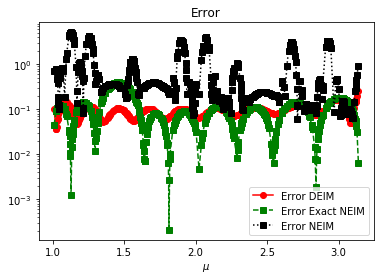

In [6]:
MAX_MODES = 10
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

test_mu = np.sort(np.random.uniform(size=501)*(np.pi-1)+1)
#test_mu = np.linspace(1, np.pi, 534).reshape(-1, 1).T
DEIM_errors = []
POD_errors = []
Exact_NEIM_errors = []
Actual_NEIM_errors = []
for num_modes in range(5, MAX_MODES+1, 5):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    Exact_NEIM_approximation, Exact_NEIM_selected_indices = Exact_NEIM(mu.reshape(-1), f, u, num_modes)
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=50000) 

    exact = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ s(x, test_mu)
    DEIM_approximation = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ DEIM_proj @ s(x, test_mu)
    POD_approximation = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ u[:, :num_modes] @ u[:, :num_modes].T @ exact
    Degenerate_NEIM_approximation = np.array([V[:, :RO_DIM] @ V[:, :RO_DIM].T @ Exact_NEIM_approximation(new_mu, num_modes) for new_mu in test_mu.reshape(-1)])[:, :, 0].T
    Actual_NEIM_approximation = np.array([NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ solution_fn(np.array([[new_mu]]), s(x, new_mu)).reshape(-1, 1)).reshape(-1), num_modes) for new_mu in test_mu.reshape(-1)]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])])
    #POD_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Exact_NEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', c='r', label="Error DEIM")
    #plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])], marker='^', c='black', linestyle='dotted', label="Error POD")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='black', linestyle='dotted', label="Error NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.show()

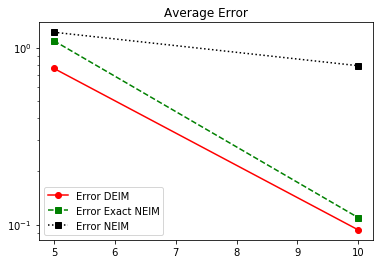

In [7]:
#print(DEIM_errors, "\n", POD_errors, "\n", Exact_NEIM_errors)    

plt.plot(np.arange(5, MAX_MODES+1, 5), DEIM_errors, marker='o', c='r', label="Error DEIM")
#plt.plot(np.arange(5, MAX_MODES+1, 5), POD_errors, marker='^', c='black', linestyle='dotted', label="Error POD")
plt.plot(np.arange(5, MAX_MODES+1, 5), Exact_NEIM_errors, marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
plt.plot(np.arange(5, MAX_MODES+1, 5), Actual_NEIM_errors, marker='s', c='black', linestyle='dotted', label="Error NEIM")
plt.yscale("log")
plt.legend()
plt.title("Average Error")
plt.show()

In [ ]:
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS, dtype=np.double).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS, dtype=np.double).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM), dtype=np.double)
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM), dtype=np.double)
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

test_mu = np.sort(np.random.uniform(size=501)*(np.pi-1)+1)
num_modes = 5
NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=50000) 


In [ ]:
approx0 = NEIM_approximation(3.0, ro_sols[0], num_modes=1)
for i in range(ro_sols.shape[0]):
    print(np.linalg.norm(NEIM_approximation(3.0, ro_sols[i], num_modes=1) - approx0))